In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split , Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import BinaryAccuracy
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd



# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
path = 'data'

In [ ]:
! kaggle datasets download -d cashbowman/ai-generated-images-vs-real-images

path = 'ai-generated-images-vs-real-images'

import zipfile
with zipfile.ZipFile('ai-generated-images-vs-real-images.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

In [19]:
# Create an ImageFolder object
data = datasets.ImageFolder(root=path)

# Extract labels from the dataset
images, labels = zip(*data.samples)

# Split data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)

# Split train set into train and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels)

# Zip train images with train labels and create DataFrame
train_data_df = pd.DataFrame({'images': train_images, 'labels': train_labels})

# Zip test images with test labels and create DataFrame
test_data_df = pd.DataFrame({'images': test_images, 'labels': test_labels})

# Zip train images with train labels and create DataFrame
val_data_df = pd.DataFrame({'images': val_images, 'labels': val_labels})

In [21]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)

        # Convert image to tensor
        image = self.transform(image)

        # Ensure image has three channels (RGB)
        if image.shape[0] == 1:  # If grayscale, convert to RGB
            image = image.expand(3, -1, -1)  # Expand grayscale to three channels
        elif image.shape[0] == 4:  # If RGBA, remove alpha channel
            image = image[:3]  # Remove alpha channel

        label = self.dataframe.iloc[idx, 1]

        return image, label

img_size = 224  # Adjust as per your requirement

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(size=img_size, scale=(0.8, 1.0)),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Assuming RGB images
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Assuming RGB images
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Assuming RGB images
])

# Create custom datasets for train and test sets
train_dataset = CustomImageDataset(train_data_df, transform=train_transform)
test_dataset = CustomImageDataset(test_data_df, transform=test_transform)
val_dataset = CustomImageDataset(val_data_df, transform=val_transform)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

# Print the counts
print("Number of batches in train_loader:", len(train_loader))
print("Number of batches in test_loader:", len(test_loader))
print("Number of batches in val_loader:", len(val_loader))

Number of batches in train_loader: 20
Number of batches in test_loader: 7
Number of batches in val_loader: 5


In [23]:
model = models.resnet18(weights = 'DEFAULT')
# Freeze pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier to output binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\louis/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [ ]:
model = models.efficientnet_b1(weights = 'DEFAULT')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

In [24]:
from torchinfo import summary
summary(model, input_size = [1,3,112,112],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 18,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape        Output Shape       Param #            Trainable
ResNet (ResNet)                          [1, 3, 112, 112]   [1, 1]             --                 Partial
├─Conv2d (conv1)                         [1, 3, 112, 112]   [1, 64, 56, 56]    (9,408)            False
├─BatchNorm2d (bn1)                      [1, 64, 56, 56]    [1, 64, 56, 56]    (128)              False
├─ReLU (relu)                            [1, 64, 56, 56]    [1, 64, 56, 56]    --                 --
├─MaxPool2d (maxpool)                    [1, 64, 56, 56]    [1, 64, 28, 28]    --                 --
├─Sequential (layer1)                    [1, 64, 28, 28]    [1, 64, 28, 28]    --                 False
│    └─BasicBlock (0)                    [1, 64, 28, 28]    [1, 64, 28, 28]    --                 False
│    │    └─Conv2d (conv1)               [1, 64, 28, 28]    [1, 64, 28, 28]    (36,864)           False
│    │    └─BatchNorm2d (bn1)            [1, 64, 28, 28]    [1, 

In [26]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.best_accuracy = None  # New attribute to track best accuracy
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss, val_accuracy):
        if self.best_loss is None or val_loss < self.best_loss:  # Update if val_loss is better
            self.best_loss = val_loss
            self.best_accuracy = val_accuracy  # Update best accuracy along with best loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"

        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"

        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs. " \
                          # f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs. " \
                              f"Best Loss: {self.best_loss:.4f}, Best Accuracy: {self.best_accuracy:.2f}%"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

# Define EarlyStopping
early_stopping = EarlyStopping(patience = 10, min_delta = 0.0)

In [27]:
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Define EarlyStopping
early_stopping = EarlyStopping(patience = 10, min_delta = 0.0)

In [29]:
from tqdm.autonotebook import tqdm

def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):

    model.train()

    train_loss = 0.
    accuracy_train = BinaryAccuracy(threshold = 0.5).to(device)

    for batch,(X,y) in enumerate(tqdm(dataloader)):
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)

        y_pred = model(X).squeeze()
        loss = loss_fn(y_pred, y)
        train_loss += loss.detach().cpu().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_proba = torch.sigmoid(y_pred)
        accuracy_train.update(y_proba, y)

    train_accuracy = accuracy_train.compute()
    train_loss = train_loss/len(dataloader)


    return train_loss, train_accuracy

def val_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module):

    model.eval()

    test_loss = 0.
    accuracy_test = BinaryAccuracy(threshold = 0.5).to(device)

    for batch,(X,y) in enumerate(tqdm(dataloader)):
        X,y = X.to(device,dtype=torch.float32), y.to(device,dtype=torch.float32)

        y_pred = model(X).squeeze()

        loss = loss_fn(y_pred, y)
        test_loss += loss.detach().cpu().item()

        y_proba = torch.sigmoid(y_pred)
        accuracy_test.update(y_proba, y)

    test_accuracy = accuracy_test.compute()
    test_loss = test_loss/len(dataloader)

    return test_loss, test_accuracy

In [36]:
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          val_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimzier:torch.optim.Optimizer,
          epochs:int):

    best_val_loss = float('inf')

    results = {'train_loss':[],
               'train_accuracy':[],
               'val_loss':[],
               'val_accuracy':[]}

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model,
                                                dataloader = train_dataloader,
                                                loss_fn = loss_fn,
                                                optimizer = optimizer)

        val_loss, val_accuracy = val_step(model = model,
                                             dataloader = val_dataloader,
                                             loss_fn = loss_fn)



        print(f"Epoch: {epoch+1} | ",
              f"Train Loss: {train_loss:.4f} | ",
              f"Train Accuracy: {train_accuracy:.4f} | ",
              f"Validation Loss: {val_loss:.4f} | ",
              f"Validation Accuracy: {val_accuracy:.4f}")


        print(early_stopping.status)
        if early_stopping(model,val_loss,val_accuracy):
            print(early_stopping.status)
            print("Early Stopping!!")
            test_loss, test_accuracy = val_step(model = model,
                                      dataloader = test_dataloader,
                                      loss_fn = loss_fn)
            print(f"Test Loss: {test_loss:.4f} | ",
              f"Test Accuracy: {test_accuracy:.4f}")
            break

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy.detach().cpu().item())
        results["val_loss"].append(val_loss)
        results["val_accuracy"].append(val_accuracy.detach().cpu().item())

    test_loss, test_accuracy = val_step(model = model,
                          dataloader = test_dataloader,
                          loss_fn = loss_fn)
    print(f"Test Loss: {test_loss:.4f} | ",
      f"Test Accuracy: {test_accuracy:.4f}")
    return results

In [37]:
# Training
EPOCHS = 200
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

MODEL_RESULTS = train(model, train_loader, val_loader, test_loader, criterion, optimizer, EPOCHS)

  0%|          | 0/20 [00:00<?, ?it/s]


100%|██████████| 20/20 [00:54<00:00,  2.75s/it]

100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


Epoch: 1 |  Train Loss: 0.6242 |  Train Accuracy: 0.6254 |  Validation Loss: 0.5848 |  Validation Accuracy: 0.6795



100%|██████████| 20/20 [01:08<00:00,  3.44s/it]

100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


Epoch: 2 |  Train Loss: 0.6041 |  Train Accuracy: 0.6656 |  Validation Loss: 0.5773 |  Validation Accuracy: 0.6667
Improvement found, counter reset to 0. 


100%|██████████| 7/7 [00:23<00:00,  3.38s/it]


Test Loss: 0.5810 |  Test Accuracy: 0.6205


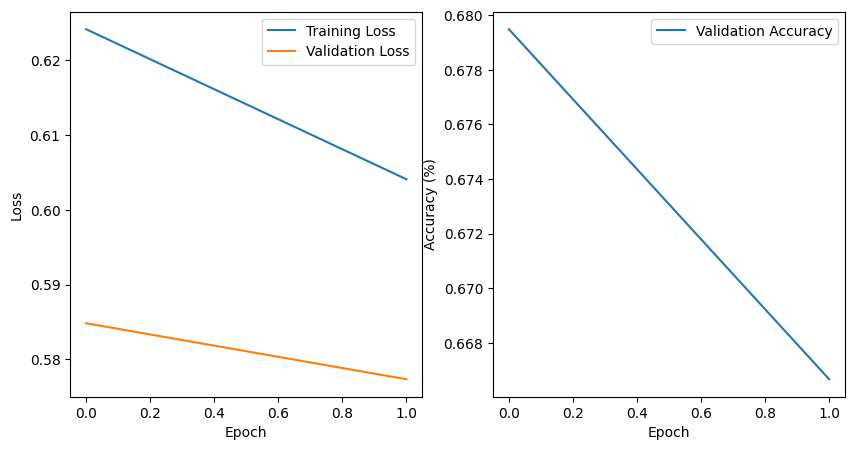

In [38]:
# Plotting training and validation metrics
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(MODEL_RESULTS["train_loss"], label = 'Training Loss')
plt.plot(MODEL_RESULTS["val_loss"], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(MODEL_RESULTS["val_accuracy"], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
# Plotting confusion matrix for validation data
model.eval()
allLabels = []
allPreds = []

testLoader = test_loader
with torch.no_grad():
    for inputs, labels in testLoader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()

        outputs = model(inputs)
        predictions = (torch.sigmoid(outputs) > 0.5).float()

        allLabels.extend(labels.cpu().numpy())
        allPreds.extend(predictions.cpu().numpy())

        # for i in range(len(inputs.cpu())):
        #   image = inputs.cpu()[i]
        #   label = labels.cpu().numpy()[i]
        #   prediction = predictions.cpu().numpy()[i]
        #   if label != prediction:
        #     # Plotting the image
        #     plt.imshow(image.permute(1, 2, 0))
        #     plt.title(f"Label: {label}, Prediction: {prediction}")
        #     plt.axis('off')
        #     plt.show()



allLabels = np.array(allLabels)
allPreds = np.array(allPreds)

matrix = confusion_matrix(allLabels, allPreds)

classes = ['aiart', 'realart']  # Define your classes manually
sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = classes, yticklabels = classes, cbar = False)
plt.title('Confusion Matrix - Validation Set', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.show()